In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
from sklearn import linear_model, datasets

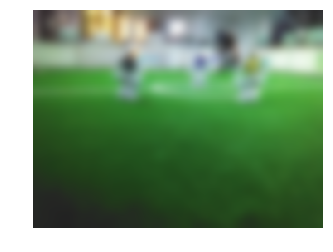

In [6]:
# Change path according to image you want to test on
test_img = 'imageset_131/16_02_2018__11_18_08_0046_upper.png'
img = cv2.imread(test_img)

# Apply Gaussian blur (note: is quite expensive)
blur = cv2.GaussianBlur(img,(71,71),10)

# Show the image
plt.imshow(blur)
plt.axis('off')
plt.show()

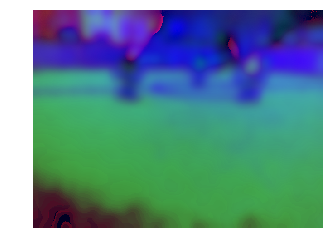

In [7]:
# Convert from RGB to HSV
hsv =  cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)

plt.imshow(hsv)
plt.axis('off')
plt.show()

In [10]:
def findgreen(image):
    ''' 
    Returns an image thresholded on a value that is representative of the 
    colour green of the grass. 
    '''
    # Through experimentation found to be a good threshold
    thres = 63
    
    # Random sampling of green HSV values in the lower part (grass) of the image
    ys = np.random.choice(np.linspace(200,479,278),100)
    xs = np.random.choice(np.linspace(0,600,601),100)
    
    # Find the most common value
    values = [image[int(ys[i]), int(xs[i])] for i in range(100)]
    countVal = Counter(values)
    modus = countVal.most_common(1)[0][0]

    # Calculating the ranges in which pixels are considered to be 'green'
    # Using the OpenCV inRange function to threshold pixels on a range of values
    minmod = np.array(np.array(modus) - thres)
    maxmod = np.array(np.array(modus) + thres)
    nimage = cv2.inRange(image,minmod,maxmod)
    
    return nimage

403.45848375451266 59.0
162
162


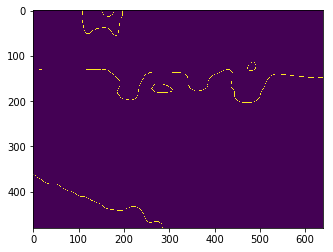

In [11]:
# Get Hue, Saturation Value channel values
h,s,v = cv2.split(hsv)
# Get image thresholded on a representative green value
new = findgreen(np.array(s))

# Apply Canny Edge detector to find edge point candidates
# for the line separating the field from the rest of the image
edge = cv2.Canny(new, 20,40)
# Find line using RANSAC
ransac = linear_model.RANSACRegressor()
y,x = np.argwhere(edge == 255)[:,0], np.argwhere(edge == 255)[:,1]

plt.imshow(edge)

In [12]:
#preprocess:
bot_mask = y < 400
xp = x[bot_mask]
yp = y[bot_mask]
data = np.array([xp,yp]).T
print(data)

[[109   0]
 [151   0]
 [178   0]
 ...
 [ 83 399]
 [ 84 399]
 [ 85 399]]


In [13]:
from skimage.measure import LineModelND, ransac
# https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=ransac#skimage.measure.ransac
# https://scikit-image.org/docs/dev/auto_examples/transform/plot_ransac.html

Number of reduced points: 219 1395


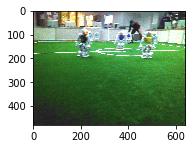

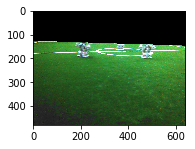

In [14]:
model_robust, inliers_mask = ransac(data, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
outliers_mask = inliers_mask == False
print("Number of reduced points:",len(data[inliers_mask]),len(data))

yin = data.T[1][inliers_mask]
xin = data.T[0][inliers_mask]
# plt.imshow(edge)
# plt.plot(xin,yin, "r.")

# from points get line:
Ny,Nx = np.shape(edge)
xdiff = xin[0] - xin[-1]
ydiff = yin[0] - yin[-1]
if xdiff == 0 or ydiff == 0:
    # in case line is horizontal or vertical
    exit()
a = ydiff/xdiff
b = yin[0] - xin[0]*a
line = a*np.arange(Nx) + b
# plt.plot(line)

# Do same for second line:
data2 = data[outliers_mask]
model_robust, inliers_mask = ransac(data2, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
yin = data2.T[1][inliers_mask]
xin = data2.T[0][inliers_mask]
plt.plot(xin,yin, "g.")

# from points get line:
Ny,Nx = np.shape(edge)
xdiff = xin[0] - xin[-1]
ydiff = yin[0] - yin[-1]
if xdiff == 0 or ydiff == 0:
    # in case line is horizontal or vertical
    exit()
a = ydiff/xdiff
b = yin[0] - xin[0]*a
line2 = a*np.arange(Nx) + b
# plt.plot(line2)
# plt.show()


# Area enclosed by first line
# Polygon coordinates [[top left], [top right], [bottom right], [bottom left]]
area1 = np.array([[[0,0],[Nx,0],[Nx,line[-1]],[0, line[0]]]], dtype=np.int32)
# ... second line
area2 = np.array( [[[0,0],[Nx,0],[Nx,line2[-1]],[0, line2[0]]]], dtype=np.int32 )
cv2.fillPoly(edge, area1, 255)
cv2.fillPoly(edge, area2, 255)

# Using tilde (~) to fill in either the field or the non-field part
plt.subplot(121), plt.imshow(~edge, cmap='Greys_r')
# plt.plot(xin,yin, "r.")

plt.imshow(img)
plt.figure()
original_copy = img
cv2.fillPoly(original_copy, area1, 0)
cv2.fillPoly(original_copy, area2, 0)
plt.subplot(122), plt.imshow(original_copy)

# plt.plot(line)
# plt.plot(line2)
plt.show()

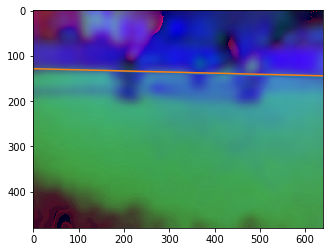

In [24]:
plt.figure()
plt.imshow(hsv)
plt.plot(line)
plt.plot(line2)
plt.show()
plt.savefig("line.png")